# Earthquake Damage in Nepal

#### Project Objective

In this project, we utilize Nepal Earthquake data obtained from the Kaggle platform, accessible via the provided link. The objective is to build a predictive model. By importing the data from PostgreSQL and considering the characteristics of buildings, the aim is to predict whether a building is likely to experience similar damage in the event of a comparable earthquake.

In [38]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

In [39]:
con = ps.connect(dbname="nepal_earthquake",
                user = "postgres",
                password = "MH329923",
                host = "localhost",
                port = "5433")

In [40]:
sql = """SELECT * 
        FROM building_df"""

In [41]:
df = sqlio.read_sql_query(sql, con)

C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_7364\2699896095.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql, con)


In [42]:
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,damage_grade,superstructure
0,120101000011,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Grade 3,has_superstructure_mud_mortar_stone
1,120101000021,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Grade 5,has_superstructure_mud_mortar_stone
2,120101000031,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Grade 2,has_superstructure_mud_mortar_stone
3,120101000041,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Grade 2,has_superstructure_mud_mortar_stone
4,120101000051,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Grade 1,has_superstructure_mud_mortar_stone


## Explore

In [43]:
df.shape

(762106, 14)

The dataset contains 762106 rows and 21 columns

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   building_id             762106 non-null  int64 
 1   age_building            762106 non-null  int64 
 2   plinth_area_sq_ft       762106 non-null  int64 
 3   height_ft_pre_eq        762106 non-null  int64 
 4   height_ft_post_eq       762106 non-null  int64 
 5   land_surface_condition  762106 non-null  object
 6   foundation_type         762106 non-null  object
 7   roof_type               762106 non-null  object
 8   ground_floor_type       762106 non-null  object
 9   other_floor_type        762106 non-null  object
 10  position                762105 non-null  object
 11  plan_configuration      762105 non-null  object
 12  damage_grade            762094 non-null  object
 13  superstructure          762106 non-null  object
dtypes: int64(5), object(9)
memory usage:

In [45]:
# exploring null values
df.isnull().sum()

building_id                0
age_building               0
plinth_area_sq_ft          0
height_ft_pre_eq           0
height_ft_post_eq          0
land_surface_condition     0
foundation_type            0
roof_type                  0
ground_floor_type          0
other_floor_type           0
position                   1
plan_configuration         1
damage_grade              12
superstructure             0
dtype: int64

In [46]:
df = df.dropna()

In [47]:
df.set_index('building_id', inplace=True)

In [48]:
df.isnull().sum()

age_building              0
plinth_area_sq_ft         0
height_ft_pre_eq          0
height_ft_post_eq         0
land_surface_condition    0
foundation_type           0
roof_type                 0
ground_floor_type         0
other_floor_type          0
position                  0
plan_configuration        0
damage_grade              0
superstructure            0
dtype: int64

Main focus will be on damage sustende by the building

In [49]:
df["damage_grade"].value_counts()

Grade 5    275766
Grade 4    183844
Grade 3    136412
Grade 2     87257
Grade 1     78815
Name: damage_grade, dtype: int64

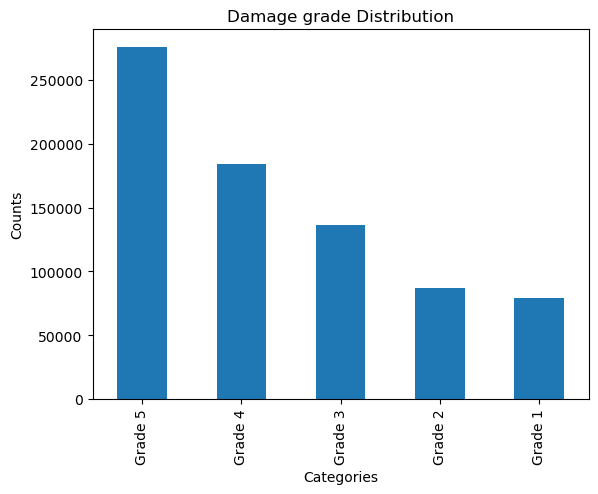

In [50]:
df["damage_grade"].value_counts().plot(kind='bar')
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.title("Damage grade Distribution")
plt.show();

We will make a new column "severe_damage" to classify the damage. For buildings where the "damage_grade" is Grade 4 or above, "severe_damage" should be 1. for all other buildings "severe_damage" should be 0. Then droping the damage_column. 

In [51]:
# first change into integer
df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
# creating new column
df["severe_damage"] = (df["damage_grade"]>3).astype(int)
df.drop(columns=["damage_grade"], inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762094 entries, 120101000011 to 366709001281
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   age_building            762094 non-null  int64 
 1   plinth_area_sq_ft       762094 non-null  int64 
 2   height_ft_pre_eq        762094 non-null  int64 
 3   height_ft_post_eq       762094 non-null  int64 
 4   land_surface_condition  762094 non-null  object
 5   foundation_type         762094 non-null  object
 6   roof_type               762094 non-null  object
 7   ground_floor_type       762094 non-null  object
 8   other_floor_type        762094 non-null  object
 9   position                762094 non-null  object
 10  plan_configuration      762094 non-null  object
 11  superstructure          762094 non-null  object
 12  severe_damage           762094 non-null  int32 
dtypes: int32(1), int64(4), object(8)
memory usage: 78.5+ MB


In [53]:
# removing the post earthquake columns because we want to predict before it.
drop_cols = [col for col in df.columns if "post_eq" in col]
df.drop(columns=drop_cols, inplace=True)

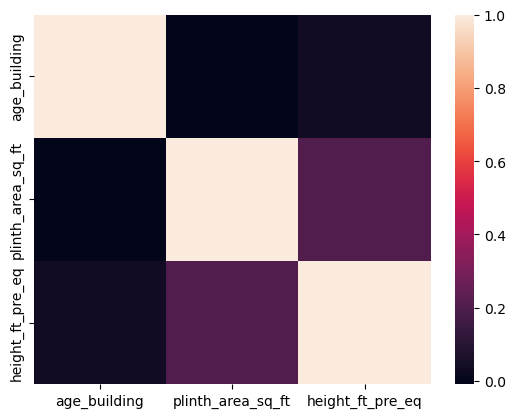

In [54]:
# Creating a correlation matrix
correlation = df.select_dtypes("number").drop(columns= "severe_damage").corr()
# plot heatmap of correlation
sns.heatmap(correlation);

There is no multicolinearity between numerical data

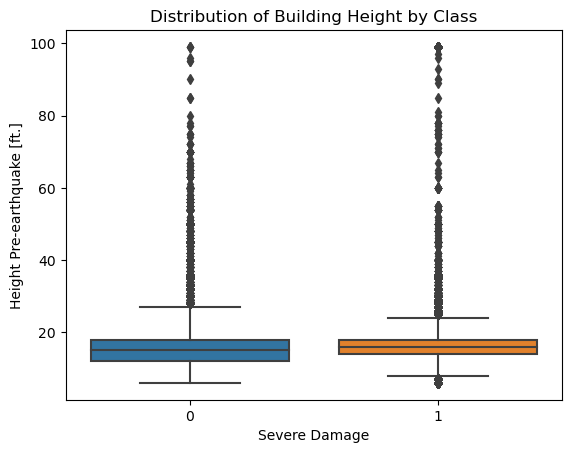

In [55]:
# Create boxplot
sns.boxplot(x="severe_damage", y ="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

* Observation: It shows identical distribution of damage based on height, there is no much difference  

In [56]:
# Relative proportion of severe_damage
df["severe_damage"].value_counts(normalize=True)

1    0.603088
0    0.396912
Name: severe_damage, dtype: float64

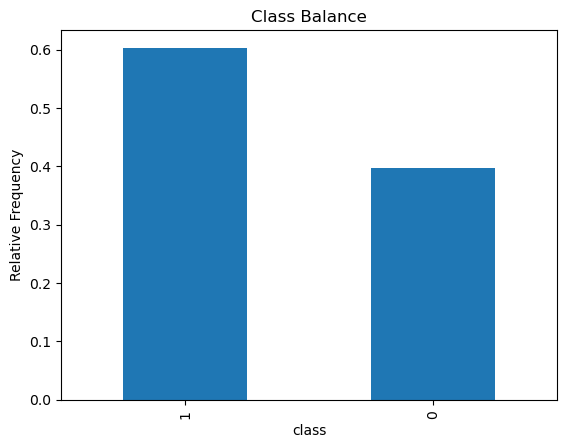

In [57]:
# plot count of "severe_damage"
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="class", ylabel="Relative Frequency", title = "Class Balance");

* Observation: The positive class(1) and negative class(0) are in 60-40 ratio so it's Okay class.

In [58]:
# class distribution
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6030883329353072 0.39691166706469283


In [59]:
# Create pivot table
foundation_pivot = pd.pivot_table(df, index="foundation_type", values="severe_damage", aggfunc=np.mean
                                 ).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


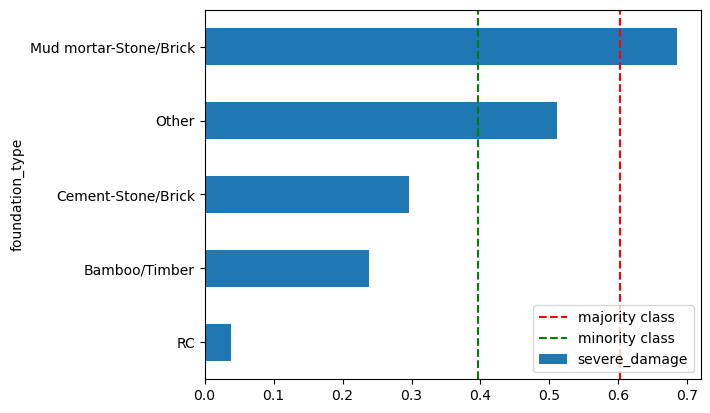

In [60]:
# lets see the upper table in picture form. plot bar chart of foundation_pivot
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class")
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class")
plt.legend(loc="lower right");

* Observation: 'Mud mortar-Stone/Brick' foundation is way above the majority boundry. on other side the RC(Reinforced concreate) have much lower severely damage buildings. Foundation of the building really matters in the for safety. 

In [61]:
# check for low- and high-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

There is no observation of high cardinality or low cadinality. 

## Split

In [62]:
# Target and feature assigning
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [36]:
# Randomized train-test split model into 80-20 percentage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=420
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (609675, 11)
y_train shape: (609675,)
X_test shape: (152419, 11)
y_test shape: (152419,)


## Logistic Regression Model Building

### Baseline

Baseline is minimum accuracy that the model should perform. 

In [ ]:
acc = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc, 2))

If the model only selected the majority group then it would give 60% accurate result, so that would be the baseline(minimum performance expected). 

In [ ]:
# Buidling Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

# Fit model to training data
model.fit(X_train, y_train)

Calculating the training and test accuracy scores for model

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 5))
print("Test Accuracy:", round(acc_test, 5))

* Accuracy score is beat by the model for both training and testing Model.

## Communication

In [ ]:
# probabilities of class of top 5 rows
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

In [ ]:
features_LR = model.named_steps["onehotencoder"].get_feature_names_out()
importances_LR = model.named_steps["logisticregression"].coef_[0]

In [ ]:
odds_ratios_LR = pd.Series(np.exp(importances_LR), index=features_LR).sort_values()
odds_ratios_LR.head()

In [ ]:
# Horizontal bar chart, five highest coefficients
odds_ratios_LR.tail().plot(kind="barh")
plt.xlabel("Odds Ratio of Logistic Regression");

In [ ]:
# Horizontal bar chart, five smallest coefficients
odds_ratios_LR.head().plot(kind="barh")
plt.axvline(
    minority_class_prop, linestyle="--", color="green")
plt.xlabel("Odds Ratios of Logistic Regression");

* Observation: The RC material in different part of building will decrease the chances of damage.

## Decision Tree Classifier Model

In [ ]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Build Model
model2 = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(random_state=42))
# Fit model to training data
model2.fit(X_train_2, y_train_2)

In [ ]:
# Performance Evaluation
acc_train_2 = accuracy_score(y_train_2, model2.predict(X_train_2))
acc_val_2 = model2.score(X_val_2, y_val_2)

print("Training Accuracy:", round(acc_train_2, 5))
print("Validation Accuracy:", round(acc_val_2, 5))

The performance on Training model is really good but barely crossing the baseline. 

In [ ]:
# Checking the decision tree classfier depth
tree_depth = model2.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

### Hyperparameter Tuning

In [ ]:
# Checking what would be the best depth parameter for decision Tree Classifier
depth_hyperparams = range(1, 60, 2)

In [ ]:
# Creating a hyperparameter list for training and validation accuracy scores
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # create model with 'max_depth' of 'd'
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d,random_state=420))
    # fit model to training data
    test_model.fit(X_train_2, y_train_2)
    
    # Calculating training accuracy score and appending to 'training_acc'
    training_acc.append(test_model.score(X_train_2, y_train_2))
    
    # Calculating Validation accuracy score and appending to 'validation_acc'
    validation_acc.append(test_model.score(X_val_2, y_val_2))
    
# printing top three to see
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

In [ ]:
# Validation Curve
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve")
plt.legend();

* Observation: The accuracy for both training and validation data giving best performance on the depth value of 10

### Retraining the Decision Tree Classifier with max_depth 10

In [ ]:
# Retraining Model
model2_retrain = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth = 10, random_state=42))
# Fit model to training data
model2_retrain.fit(X_train_2, y_train_2)

In [ ]:
# Performance Evaluation
acc_train_2 = accuracy_score(y_train_2, model2_retrain.predict(X_train_2))
acc_val_2 = model2_retrain.score(X_val_2, y_val_2)

print("Training Accuracy:", round(acc_train_2, 5))
print("Validation Accuracy:", round(acc_val_2, 5))

In [ ]:
test_acc = model2_retrain.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 5))

 model performing well bitting both baseline and Logistic Regression.

## Communication 

In [ ]:
# plot of decision Tree Classifier
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model2_retrain.named_steps["decisiontreeclassifier"],
    feature_names=X_train_2.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

* Observation From Decision Tree Classfier
1. Gini impurity get lower and lower by distribution.
2. Nodes get pure
3. The model get bluer the model strongly predicts the severely damage structure. 
4. The model get orange the model strongly predicts the not severely damage structure. 

In [ ]:
# Odds Ratios or Feature Importance
features_DT = X_train_2.columns
importances_DT = model2_retrain.named_steps["decisiontreeclassifier"].feature_importances_
print("Features:", features[:3])
print("Importances:", importances[:3])

In [ ]:
# Making a dataframe of 'Odds Ratios'
feat_imp = pd.Series(importances_DT, index=features_DT).sort_values()
feat_imp.head()

In [ ]:
# Create horizontal bar chart of odds Ratios
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Features")
plt.title("Gini Importance of features");

* Observation: Superstructure feature giving importance 67%  to model then foundation type and other features. 